In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.utils import shuffle

In [7]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [8]:
drebin = pd.read_csv("../../../6_Leveled_Datasets/Intersection_v2/Leveled_Intersection_v2_Drebin215.csv")
krono = pd.read_csv("../../../6_Leveled_Datasets/Intersection_v2/Leveled_Intersection_v2_krono.csv")
droid = pd.read_csv("../../../6_Leveled_Datasets/Intersection_v2/Leveled_Intersection_v2_DefenseDroid.csv")
moto = pd.read_csv("../../../6_Leveled_Datasets/Intersection_v2/Leveled_Intersection_v2_MotoDroid.csv")

In [12]:
#drebin.drop("Unnamed: 0", axis=1, inplace=True)
#krono.drop("Unnamed: 0", axis=1, inplace=True)
#moto.drop("Unnamed: 0", axis=1, inplace=True)
#droid.drop("Unnamed: 0", axis=1, inplace=True)

In [13]:
sorted(drebin.columns)

['ACCESS_COARSE_LOCATION',
 'ACCESS_FINE_LOCATION',
 'ACCESS_LOCATION_EXTRA_COMMANDS',
 'ACCESS_NETWORK_STATE',
 'ACCESS_WIFI_STATE',
 'ADD_VOICEMAIL',
 'BATTERY_STATS',
 'BIND_ACCESSIBILITY_SERVICE',
 'BIND_APPWIDGET',
 'BIND_DEVICE_ADMIN',
 'BIND_INPUT_METHOD',
 'BIND_REMOTEVIEWS',
 'BIND_TEXT_SERVICE',
 'BIND_VPN_SERVICE',
 'BIND_WALLPAPER',
 'BLUETOOTH',
 'BLUETOOTH_ADMIN',
 'BROADCAST_SMS',
 'BROADCAST_STICKY',
 'BROADCAST_WAP_PUSH',
 'CALL_PHONE',
 'CALL_PRIVILEGED',
 'CAMERA',
 'CHANGE_COMPONENT_ENABLED_STATE',
 'CHANGE_CONFIGURATION',
 'CHANGE_NETWORK_STATE',
 'CHANGE_WIFI_MULTICAST_STATE',
 'CHANGE_WIFI_STATE',
 'CLEAR_APP_CACHE',
 'CONTROL_LOCATION_UPDATES',
 'DELETE_CACHE_FILES',
 'DELETE_PACKAGES',
 'DISABLE_KEYGUARD',
 'DUMP',
 'EXPAND_STATUS_BAR',
 'GET_ACCOUNTS',
 'GET_PACKAGE_SIZE',
 'GET_TASKS',
 'GLOBAL_SEARCH',
 'INSTALL_LOCATION_PROVIDER',
 'KILL_BACKGROUND_PROCESSES',
 'MOUNT_FORMAT_FILESYSTEMS',
 'NFC',
 'PERSISTENT_ACTIVITY',
 'PROCESS_OUTGOING_CALLS',
 'READ_CAL

# Separação dos dados

1 >> 1720

0 >> 3146

### Conjunto de dados de Validação (30%)

In [14]:
3146 * 0.3

943.8

In [15]:
1720 * 0.3

516.0

In [16]:
Bval = drebin[drebin["class"] == 0].sample(n=944, random_state=42)
Mval = drebin[drebin["class"] == 1].sample(n=516, random_state=42)
validation = pd.concat([Bval,Mval])
indexes = validation["class"].index.tolist()
validation = shuffle(validation)
validation = validation.reset_index()
validation.drop(columns=["index"], inplace=True)
x_validation = validation.drop(columns=["class"])
y_validation = validation["class"]

In [17]:
drebin.drop(index=indexes, inplace=True)

### Conjunto de dados de Treino (40%)

In [18]:
(3146 - 944) - 944

1258

In [19]:
(1720 - 516) - 516

688

In [20]:
Btrain = drebin[drebin["class"] == 0].sample(n=1258, random_state=42)
Mtrain = drebin[drebin["class"] == 1].sample(n=688, random_state=42)
train = pd.concat([Btrain,Mtrain])
indexes = train["class"].index.tolist()
train = shuffle(train)
train = train.reset_index()
train.drop(columns=["index"], inplace=True)
x_train = train.drop(columns=["class"])
y_train = train["class"]

In [21]:
drebin.drop(index=indexes, inplace=True)
drebin = shuffle(drebin)
drebin = drebin.reset_index()
drebin.drop(columns=["index"], inplace=True)

### Conjunto de dados de Teste (30%)

In [22]:
drebin['class'].value_counts()

0    944
1    516
Name: class, dtype: int64

In [23]:
x_test = drebin.drop(columns=["class"])
y_test = drebin["class"]

In [24]:
RF = RandomForestClassifier()

In [25]:
RF.fit(x_train,y_train)

RandomForestClassifier()

In [26]:
print("Curva ROC >> ", roc_auc_score(y_test, RF.predict(x_test))*100, "%")

Curva ROC >>  76.45020365260807 %


### Os outros datasets se tornam conjuntos de dados de teste

In [27]:
x_krono = krono.drop("class", axis=1)
y_krono = krono["class"]

In [28]:
x_droid = droid.drop("class", axis=1)
y_droid = droid["class"]

In [33]:
x_moto = moto.drop("class", axis=1)
y_moto = moto["class"]

In [34]:
B_RandomForest = RandomForestClassifier()

# HIPERPARÂMETROS PADRÕES

### Treino Balanceado

In [35]:
B_RandomForest.fit(x_train,y_train)

RandomForestClassifier()

In [36]:
print("Treino balanceado")
print("Curva ROC >> ", roc_auc_score(y_test, RF.predict(x_test))*100, "%")

Treino balanceado
Curva ROC >>  76.45020365260807 %


# TESTANDO HIPERPARÂMETROS

In [38]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

B_RS = RandomizedSearchCV(B_RandomForest, random_grid, random_state=42, scoring="roc_auc",cv = 5, n_iter = 100, n_jobs=-1, verbose=2).fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   4.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   5.6s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  11.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; 

In [39]:
B_RS.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': False}

# HIPERPARÂMETROS OTIMIZADOS

In [40]:
OB_RandomForest = RandomForestClassifier(**B_RS.best_params_)

In [41]:
OB_RandomForest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=1800)

In [42]:
print("Treino balanceado")
print("Curva ROC >> ", roc_auc_score(y_test, OB_RandomForest.predict(x_test))*100, "%")

Treino balanceado
Curva ROC >>  74.10778806989885 %


# HIPERPARÂMETROS PADRÕES X HIPERPARÂMETROS OTIMIZADOS

### Balanceado

/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use o

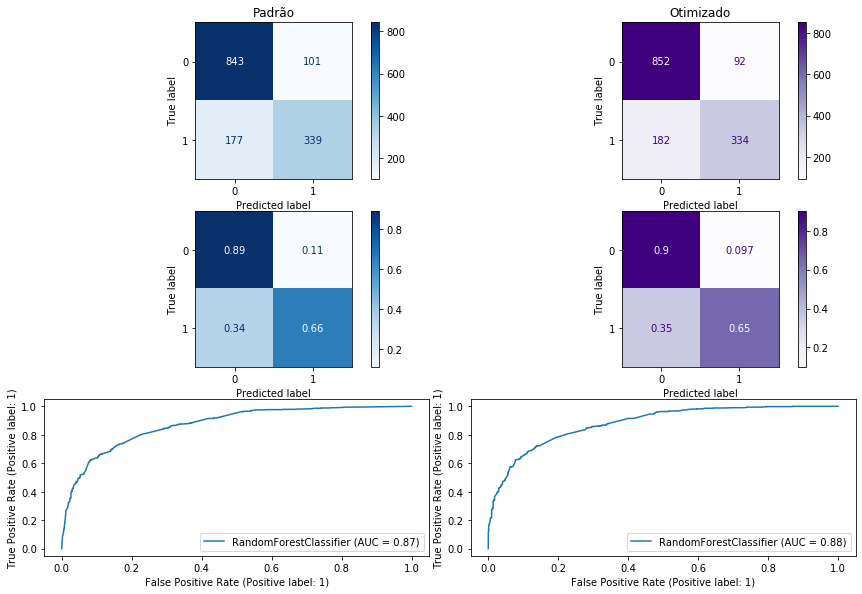

In [43]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,8))
plt.tight_layout()
ax1.set(title="Padrão")
ax2.set(title="Otimizado")
plot_confusion_matrix(B_RandomForest, x_validation, y_validation,ax=ax1, cmap = "Blues", values_format="d")
plot_confusion_matrix(OB_RandomForest, x_validation, y_validation, ax=ax2, cmap= "Purples", values_format="d")
plot_confusion_matrix(B_RandomForest, x_validation, y_validation,ax=ax3, cmap = "Blues", normalize = "true")
plot_confusion_matrix(OB_RandomForest, x_validation, y_validation, ax=ax4, cmap= "Purples", normalize = "true")
plot_roc_curve(B_RandomForest,x_validation, y_validation, ax=ax5)
plot_roc_curve(OB_RandomForest,x_validation, y_validation, ax=ax6)

In [44]:
print("PADRÃO - ROC_AUC >>",roc_auc_score(y_validation, B_RandomForest.predict(x_validation))*100, "%")

PADRÃO - ROC_AUC >> 77.49926093811588 %


In [45]:
print("OTIMIZADO - ROC_AUC >>",roc_auc_score(y_validation, OB_RandomForest.predict(x_validation))*100, "%")

OTIMIZADO - ROC_AUC >> 77.49145972933911 %


# VALIDANDO NOS SUBSETS DE INTERSECÇÃO

#### KRONODROID

/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use o

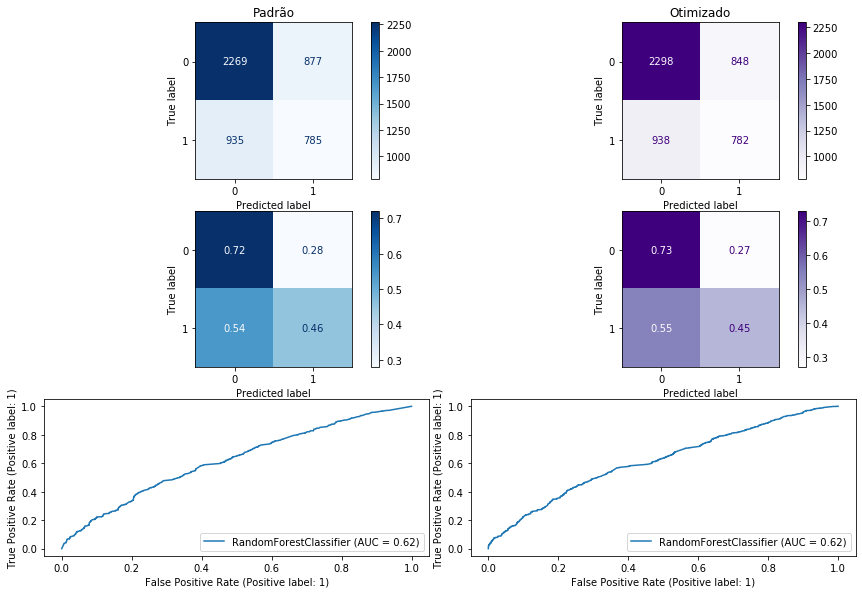

In [46]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,8))
plt.tight_layout()
ax1.set(title="Padrão")
ax2.set(title="Otimizado")
plot_confusion_matrix(B_RandomForest, x_krono, y_krono,ax=ax1, cmap = "Blues", values_format="d")
plot_confusion_matrix(OB_RandomForest, x_krono, y_krono, ax=ax2, cmap= "Purples", values_format="d")
plot_confusion_matrix(B_RandomForest, x_krono, y_krono,ax=ax3, cmap = "Blues", normalize = "true")
plot_confusion_matrix(OB_RandomForest, x_krono, y_krono, ax=ax4, cmap= "Purples", normalize = "true")
plot_roc_curve(B_RandomForest,x_krono, y_krono, ax=ax5)
plot_roc_curve(OB_RandomForest,x_krono, y_krono, ax=ax6)

In [47]:
print("krono - ROC_AUC >>",roc_auc_score(y_krono, OB_RandomForest.predict(x_krono))*100, "%")

krono - ROC_AUC >> 59.25512648028505 %


#### DEFENSE DROID

/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use o

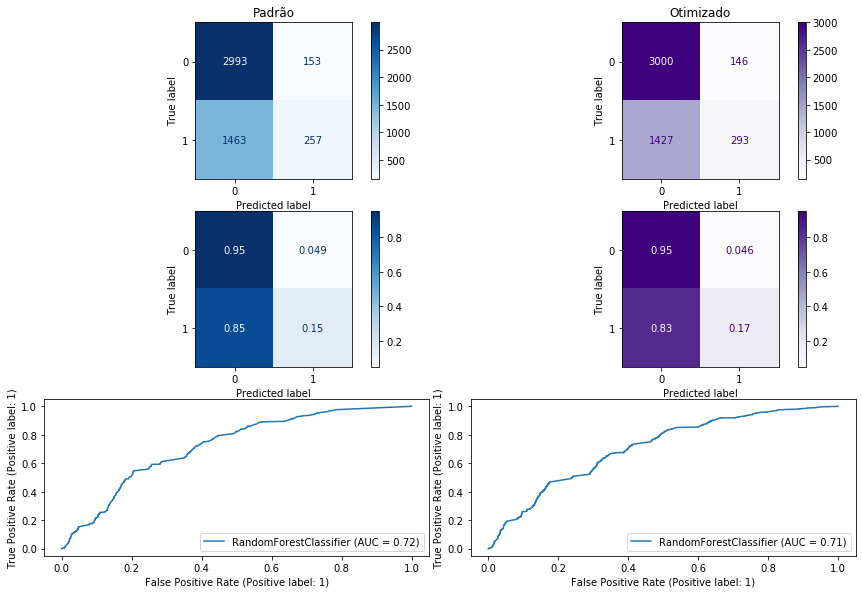

In [48]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,8))
plt.tight_layout()
ax1.set(title="Padrão")
ax2.set(title="Otimizado")
plot_confusion_matrix(B_RandomForest, x_droid, y_droid,ax=ax1, cmap = "Blues", values_format="d")
plot_confusion_matrix(OB_RandomForest, x_droid, y_droid, ax=ax2, cmap= "Purples", values_format="d")
plot_confusion_matrix(B_RandomForest, x_droid, y_droid,ax=ax3, cmap = "Blues", normalize = "true")
plot_confusion_matrix(OB_RandomForest, x_droid, y_droid, ax=ax4, cmap= "Purples", normalize = "true")
plot_roc_curve(B_RandomForest,x_droid, y_droid, ax=ax5)
plot_roc_curve(OB_RandomForest,x_droid, y_droid, ax=ax6)

In [49]:
print("DEFENSE DROID - ROC_AUC >>",roc_auc_score(y_droid, OB_RandomForest.predict(x_droid))*100, "%")

DEFENSE DROID - ROC_AUC >> 56.1970349946037 %


#### MOTODROID

/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/overycall/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use o

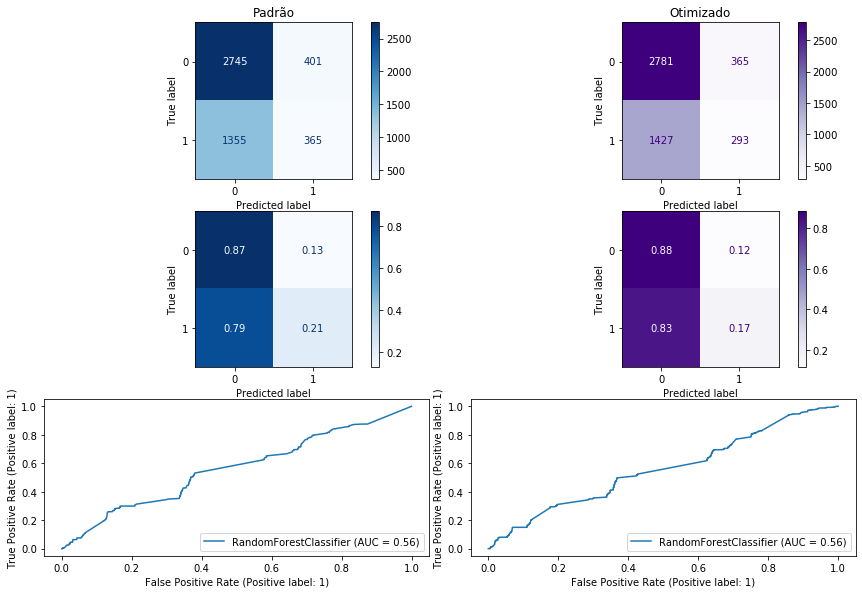

In [50]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,8))
plt.tight_layout()
ax1.set(title="Padrão")
ax2.set(title="Otimizado")
plot_confusion_matrix(B_RandomForest, x_moto, y_moto,ax=ax1, cmap = "Blues", values_format="d")
plot_confusion_matrix(OB_RandomForest, x_moto, y_moto, ax=ax2, cmap= "Purples", values_format="d")
plot_confusion_matrix(B_RandomForest, x_moto, y_moto,ax=ax3, cmap = "Blues", normalize = "true")
plot_confusion_matrix(OB_RandomForest, x_moto, y_moto, ax=ax4, cmap= "Purples", normalize = "true")
plot_roc_curve(B_RandomForest,x_moto, y_moto, ax=ax5)
plot_roc_curve(OB_RandomForest,x_moto, y_moto, ax=ax6)

In [51]:
print("MOTO DROID - ROC_AUC >>",roc_auc_score(y_moto, OB_RandomForest.predict(x_moto))*100, "%")

MOTO DROID - ROC_AUC >> 52.71642469581159 %


### Resultados

In [52]:
print("DREBIN - ROC_AUC >>",roc_auc_score(y_validation, OB_RandomForest.predict(x_validation))*100, "%")
print("KRONO DROID - ROC_AUC >>",roc_auc_score(y_krono, OB_RandomForest.predict(x_krono))*100, "%")
print("DEFENSE DROID - ROC_AUC >>",roc_auc_score(y_droid, OB_RandomForest.predict(x_droid))*100, "%")
print("MOTO DROID - ROC_AUC >>",roc_auc_score(y_moto, OB_RandomForest.predict(x_moto))*100, "%")

DREBIN - ROC_AUC >> 77.49145972933911 %
KRONO DROID - ROC_AUC >> 59.25512648028505 %
DEFENSE DROID - ROC_AUC >> 56.1970349946037 %
MOTO DROID - ROC_AUC >> 52.71642469581159 %


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=be34dc1b-561d-4c90-bae1-66eed919bb55' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>